# Spectral Filtering

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

from coma.utils.decomposition import GraphSpectralFiltering
from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [3]:
%aimport coma.utils.decomposition

## Load Dataset

In [4]:
meshes = torch.load('training_meshes.pt')
features = pd.read_csv('training_metadata.csv')
features.head()

,Unnamed: 0,eid,sex,age,structure_volume,brain_volume
0,8809,3820915,0,56,23764,1041180
1,11675,3677460,1,66,22000,1143400
2,9633,4383421,1,63,27148,1369520
3,8374,3069151,0,59,20223,980627
4,14213,1457636,0,50,21183,1386220


In [5]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

In [6]:
print('Verifying Euler Characteristic')
for file in os.listdir('/vol/biomedic3/bglocker/brainshapes/5026976/'):
    x = f'/vol/biomedic3/bglocker/brainshapes/5026976/{file}'
    print(x)
    _template = pv.read(x)
    _faces = _template.faces.T.reshape(-1, 4)[:, 1:]
    _spectral_filter = GraphSpectralFiltering(_template.points.shape[0], None)
    _spectral_filter.fit(_faces)
    print(- np.triu(_spectral_filter.adj).sum() + _template.points.shape[0] + _faces.shape[0])

Verifying Euler Characteristic
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Caud_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Caud_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Hipp_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Hipp_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Pall_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Pall_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Puta_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Puta_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Accu_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Accu_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-R_Thal_first.vtk
2.0
/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-L_Thal_first.vtk
2.0
/vol/bi

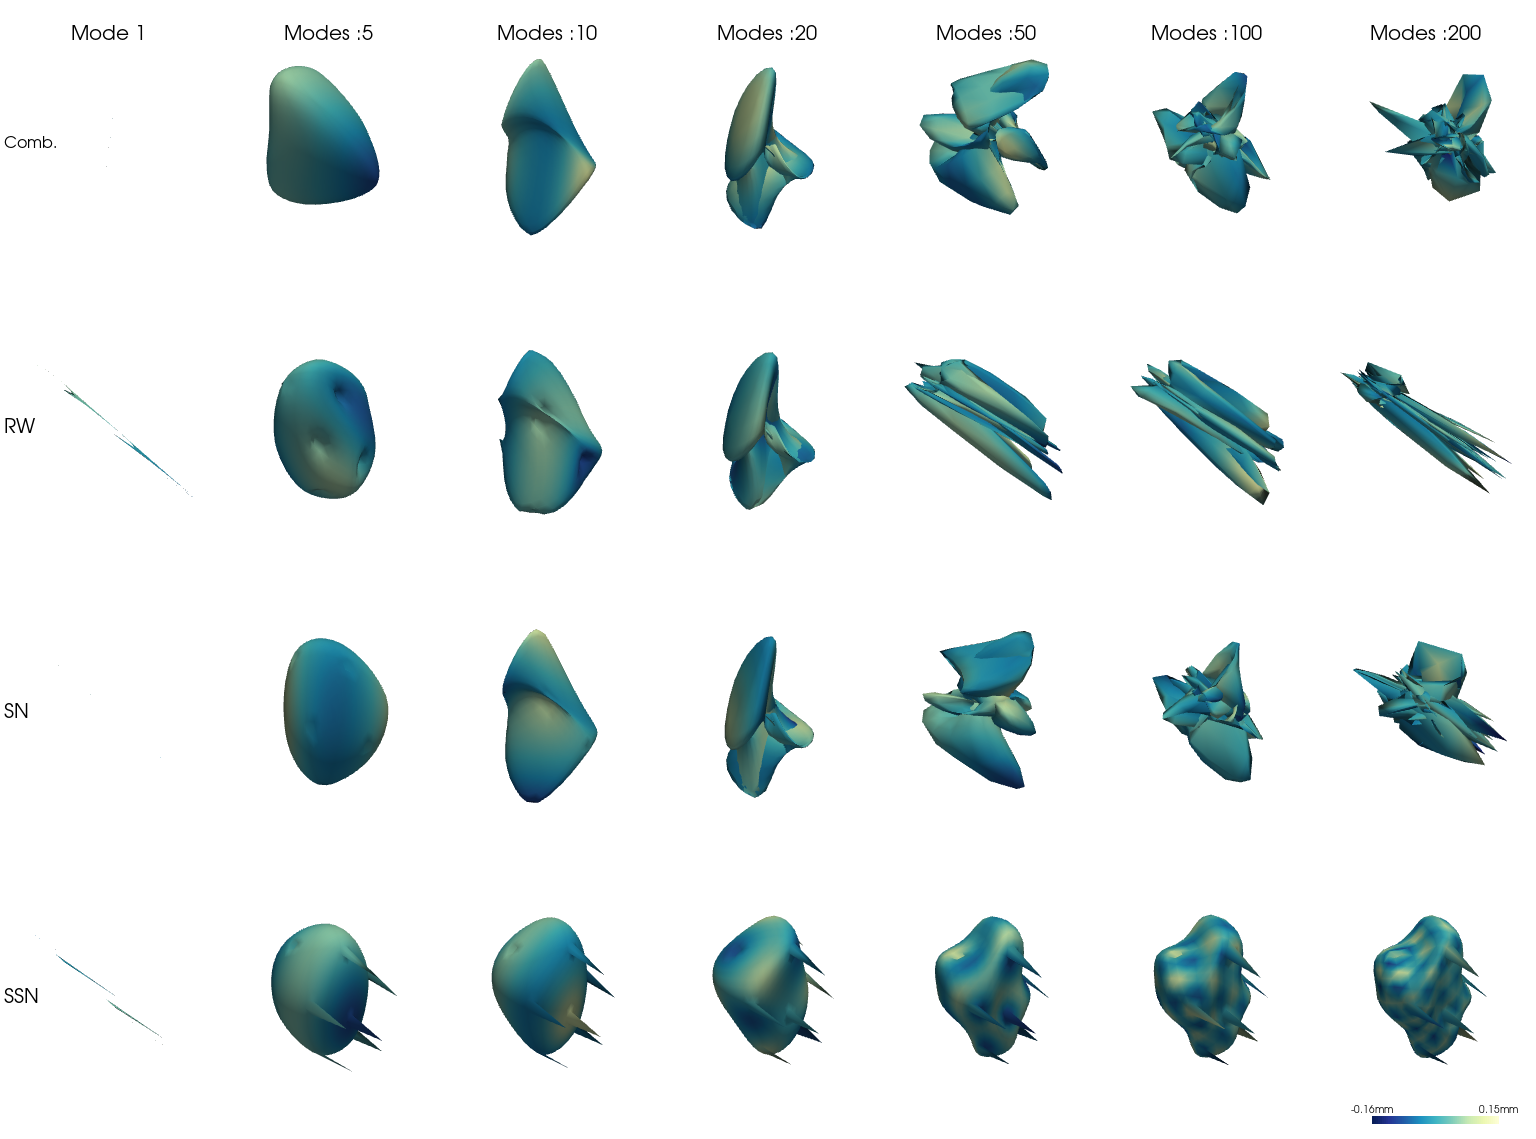

[(109.56426105134584, -60.11109867460631, 123.68080958955385),
 (47.453474044799805, -122.22188568115234, 61.57002258300781),
 (0.0, 0.0, 1.0)]

In [26]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

modes = [2, 6, 11, 21, 51, 101, 201]
n_modes = len(modes)
polydatas = []
lap_types = [None, 'rw', 'sym', 'sym_scaled']
n_laps = len(lap_types)
colors = []

for lap_type in lap_types:
    spectral_filter = GraphSpectralFiltering(template.points.shape[0], lap_type)
    spectral_filter.fit(faces)

    for mode in modes:
        x = -spectral_filter.project(template.points, dim=mode)
        template_copy = template.copy()
        template_copy.points = x
        polydatas.append(template_copy)

    colors.append(spectral_filter.e_vecs[:, [m - 1 for m in modes]].T)

# -----------------------------------------
width = 768 * 2
height = int(width / (1.618 / 1.2))

rotations = [(0, 0, 240)]

plotter = pv.Plotter(
    shape=(n_laps, n_modes),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_meshes_pyvista(
    plotter,
    polydatas,
    rotations=rotations * n_modes * n_laps,
    vertexcolors=np.concatenate(colors, axis=0),
    vertexscalar='distance',
    scalar_bar_idx=n_modes * n_laps - 1,
    titles=['Mode 1'] + [f'Modes :{no - 1}' for no in modes[1:]] + [''] * n_modes * (n_laps - 1),
    mesh_kwargs=dict(
        smooth_shading=True
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2fmm',
    ),
    title_kwargs=dict(
        font_size=8,
    ),
)

plotter.subplot(0, 0)
actor = plotter.add_text('Comb.', position='left_edge', font_size=8)
plotter.subplot(1, 0)
actor = plotter.add_text('RW', position='left_edge', font_size=8)
plotter.subplot(2, 0)
actor = plotter.add_text('SN', position='left_edge', font_size=8)
plotter.subplot(3, 0)
actor = plotter.add_text('SSN', position='left_edge', font_size=8)

plotter.show(screenshot='spectral_modes_brain_stem.png')

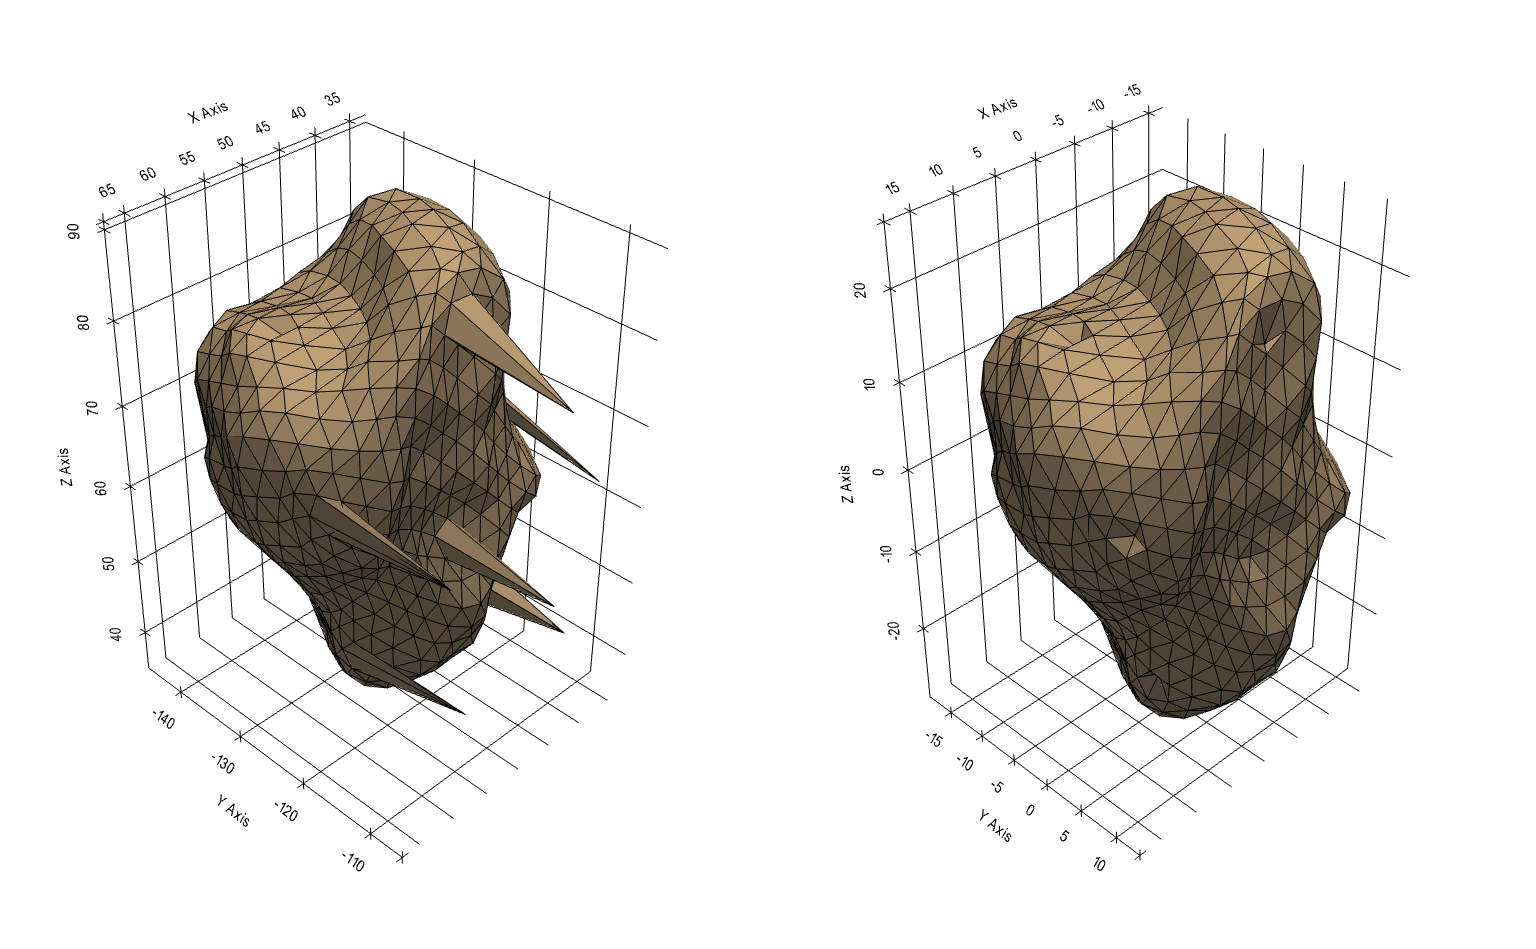

[(100.34126023091916, 97.22426728047971, 98.4976752165759),
 (0.4853992462158203, -2.631593704223633, -1.3581857681274414),
 (0.0, 0.0, 1.0)]

In [8]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]
X = template.points
dim = 300

polydatas = []

spectral_filter = GraphSpectralFiltering(template.points.shape[0], 'sym_scaled')
spectral_filter.fit(faces)
X_1 = -spectral_filter.project(X, dim=dim)

template_copy = template.copy()
template_copy.points = X_1
polydatas.append(template_copy)

modes = spectral_filter.e_vecs[:, 1:dim]
spectrum = np.diag(spectral_filter.e_vals[1:dim])
low_rank_lap = modes @ spectrum @ modes.T
mesh_proj = np.zeros_like(X)
mesh_proj[:, 0] = low_rank_lap @ X[:, 0]
mesh_proj[:, 1] = low_rank_lap @ X[:, 1]
mesh_proj[:, 2] = low_rank_lap @ X[:, 2]

template_copy = template.copy()
template_copy.points = -mesh_proj
polydatas.append(template_copy)
    
width = 768 * 2
height = int(width / (1.618))

rotations = [(0, 0, 240)]

plotter = pv.Plotter(
    shape=(1, 2),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)
plotter.show_grid()

plot_meshes_pyvista(
    plotter,
    polydatas,
    rotations=rotations * 2,
    vertexcolors=None,  # np.concatenate(colors, axis=0),
    vertexscalar='',  # 'distance',
    scalar_bar_idx=-1, # n_modes * n_laps - 1,
    titles=[''] * 2,  # n_modes * n_laps, # [f'Mode {x - 1}' for x in modes] + [''] * n_modes * (n_laps - 1),
    mesh_kwargs=dict(
        smooth_shading=False,
        show_edges=True,
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2f',
    ),
)

plotter.show_grid()
plotter.show(screenshot='spectral_modes_kernel_comparison.png')